## Imports

In [1]:
# reddit
import praw

# nlp
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# graph
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx


# config
from secrets_config import RedditSecretsConfig

# system
from datetime import datetime, timezone
from collections import defaultdict, Counter
from pytz import UTC
import pandas as pd
import unicodedata
import emoji
import csv
import ast
import re

import site
site.addsitedir("NLP")

/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## CONGIF Class

In [2]:
class CONFIG:
    INDIVIDUALS = [
        "Elon Musk",           # CEO of Tesla. Founder, product architect, and central to all decisions at Tesla.
        "Jeff Bezos",          # Amazon founder. Business and space rival to Musk (Blue Origin vs. SpaceX); often compared to Musk.
        "Larry Page",          # Google co-founder. Longtime friend of Musk; Google/Waymo competes with Tesla in autonomous driving.
        "Donald Trump",        # U.S. President. Influences public opinion and policy; has made comments on Tesla and Musk.
        "Mark Zuckerberg",     # Meta CEO. Competes with Musk in social media; has made comments on Tesla and Musk.
        "Joe Biden",           # U.S. President. Initially dismissive of Tesla in EV discussions; later acknowledged its EV leadership.
        "Cathie Wood",         # CEO of ARK Invest. Major Tesla bull and investor; forecasts extremely high valuations for Tesla.
        "Jim Cramer",          # CNBC host. Publicly flip-flopped on Tesla; currently supportive but controversial in Tesla circles.
        "Chamath Palihapitiya",# VC and SPAC investor. Public Tesla bull and Musk supporter; promoted Tesla on media.
        "Michael Burry",       # Famed for The Big Short. Publicly shorted Tesla; skeptical of valuation.
        "Gavin Newsom",        # Governor of California. Tesla's home state; has made comments on Tesla and Musk.
        "Alexandria Ocasio-Cortez", # U.S. Congresswoman. Criticized Musk and Tesla on social issues; represents a younger, progressive demographic.
        "Pete Buttigieg",      # U.S. Secretary of Transportation. Has commented on Tesla's role in EV adoption and infrastructure.
        "Bernie Sanders",      # U.S. Senator. Criticized Musk for wealth and influence; represents a progressive viewpoint on wealth inequality.
    ]

    SUBREDDITS = [
        'TeslaMotors',         # Main Tesla discussion hub
        'TeslaInvestorsClub',  # Tesla investment focused  
        'wallstreetbets',      # Retail trading community
        'investing',           # General investment discussions
        'electricvehicles',    # General EV discussions
        'technology',          # General tech discussions
        'politics',            # U.S. political discussions
        'RealTesla',           # Critical Tesla perspectives
        'elonmusk'             # Elon Musk specific
    ]

    ALIASES = {
        "Elon Musk": ["Elon", "Musk", "EM", "ElonMusk", "SpaceX", "X.com", "Tesla CEO"],
        "Jeff Bezos": ["Bezos", "Jeff", "Amazon founder", "Blue Origin", "JB"],
        "Mark Zuckerberg": ["Zuck", "Zuckerberg", "Meta CEO", "Facebook"],
        "Larry Page": ["Larry", "Google co-founder", "Alphabet"],
        "Donald Trump": ["Trump", "Donald", "POTUS 45", "45th President", "The Donald"],
        "Joe Biden": ["Biden", "President Biden", "Joe"],
        "Cathie Wood": ["Cathie", "ARK", "ARK Invest", "Cathie W", "ARKK"],
        "Jim Cramer": ["Cramer", "Mad Money", "Jim", "CNBC host"],
        "Chamath Palihapitiya": ["Chamath", "Chamath P", "Social Capital", "SPAC King"],
        "Michael Burry": ["Burry", "The Big Short", "Dr. Burry", "Scion Capital"],
        "Gavin Newsom": ["Newsom", "Governor Newsom", "CA Governor"],
        "Alexandria Ocasio-Cortez": ["AOC", "Ocasio-Cortez", "Congresswoman AOC"],
        "Pete Buttigieg": ["Buttigieg", "Mayor Pete", "Transportation Secretary"],
        "Bernie Sanders": ["Bernie", "Senator Sanders", "Sanders"],
    }

    COMPARATIVE_COMPANIES = [
        "Rivian", "NIO", "Lucid", "BYD", "Ford", "GM", "Apple", "Meta", "Palantir"
    ]

    TIME_PERIODS = {
        "<2020": ("2010-01-01", "2019-12-31"),
        "2020-2021": ("2020-01-01", "2021-12-31"),
        "2022-2023": ("2022-01-01", "2023-12-31"),
        "2024-2025": ("2024-01-01", "2025-12-31"),
    }

    POST_LIMIT = 50
    COMMENT_LIMIT = 20
    SENTIMENT_THRESHOLD = 0.07

## Reddit Client Class

In [3]:
class RedditClient:
    def __init__(self):
        self.reddit = praw.Reddit(
            client_id=RedditSecretsConfig.client_id,
            client_secret=RedditSecretsConfig.client_secret,
            user_agent=RedditSecretsConfig.user_agent
        )
        self.all_posts = []

    def _fetch_top_posts(self, subreddit_name, keyword, post_limit=CONFIG.POST_LIMIT):
        subreddit = self.reddit.subreddit(subreddit_name)
        posts = []

        for post in subreddit.search(keyword, limit=post_limit, sort='top'):
            post_info = {
                'title': post.title,
                'created_utc': datetime.fromtimestamp(post.created_utc, tz=timezone.utc),
                'score': post.score,
                'num_comments': post.num_comments,
                'comments': self._fetch_top_comments(post, CONFIG.COMMENT_LIMIT),
            }
            posts.append(post_info)
        return posts

    def _fetch_top_comments(self, post, comment_limit):
        post.comments.replace_more(limit=0)
        top_comments = post.comments[:comment_limit]
        return [
            {
                'author': str(comment.author),
                'body': comment.body,
                'score': comment.score
            }
            for comment in top_comments if comment.body not in ['[deleted]', '[removed]']
        ]

    def fetch_all_posts(self):
        for individual in CONFIG.INDIVIDUALS:
            print(f"Fetching posts for {individual}...")
            for subreddit in CONFIG.SUBREDDITS:
                posts = self._fetch_top_posts(subreddit, individual)
                self.all_posts.extend(posts)
            pd.DataFrame(posts).to_csv(f"posts_data/{individual.lower().replace(' ', '_')}.csv", index=False)

    def get_all_posts(self):
        """ returns all posts from all individuals, for the saved local files """
        to_return = []
        for individual in CONFIG.INDIVIDUALS:
            posts = pd.read_csv(f"posts_data/{individual.lower().replace(' ', '_')}.csv")
            to_return.extend(posts.to_dict(orient='records'))
        for post in to_return:
            post['comments'] = ast.literal_eval(post['comments'])
        return to_return

## Processor Class

In [4]:
class Processor:
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def _analyze_sentiment(self, text):
        score = self.sia.polarity_scores(text)['compound']
        sentiment = 'positive' if score >= CONFIG.SENTIMENT_THRESHOLD else 'negative' if score <= -CONFIG.SENTIMENT_THRESHOLD else 'neutral'
        return score, sentiment

    def normalize_text(self, text):
        text = emoji.demojize(text, delimiters=("", ""))
        text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
        text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
        text = re.sub(r'[^\w\s\.,!?\'"\-]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _assign_post_periods(self, posts):
        copied = posts.copy()
        for post in copied:
            post['periods'] = []
            for period_name, (start_str, end_str) in CONFIG.TIME_PERIODS.items():
                start = pd.to_datetime(start_str).tz_localize(UTC)
                end = pd.to_datetime(end_str).tz_localize(UTC)
                created_utc = pd.to_datetime(post['created_utc'])
                if start <= created_utc <= end:
                    post['periods'].append(period_name)
                    break
        return copied

    def process_posts(self, posts):
        with_periods = self._assign_post_periods(posts)
        for post in with_periods:
            post['title'] = self.normalize_text(post['title'])
            score, label = self._analyze_sentiment(post['title'])
            post['sentiment_score'] = score
            post['sentiment_label'] = label
            for comment in post['comments']:
                comment['body'] = self.normalize_text(comment['body'])
                score, label = self._analyze_sentiment(comment['body'])
                comment['sentiment_score'] = score
                comment['sentiment_label'] = label
        return with_periods

## Graph Class

In [5]:
class GraphMaker:
    def __init__(self, given_period:str = None):
        self.graph = nx.Graph()
        self.entities = ["Tesla"] + CONFIG.INDIVIDUALS
        self.period = given_period
        self.min_width = 0.5
        self.max_width = 10.0
        self.custom_cmap = LinearSegmentedColormap.from_list(
            "custom_red_gray_green",
            ["#f80509", "#deb603", "#0bc746"],
            N=256
        )
        self.node_sentiment = defaultdict(list)
        self.competitor_mentions = defaultdict(int)

    def _find_mentions(self, text):
        mentions = set()
        lowered = text.lower()
        for entity in self.entities:
            aliases = [entity] + CONFIG.ALIASES.get(entity, [])
            for alias in aliases:
                if alias.lower() in lowered:
                    mentions.add(entity)

        for comp in CONFIG.COMPARATIVE_COMPANIES:
            if comp.lower() in lowered:
                mentions.add(comp)
                self.competitor_mentions[comp] += 1

        return list(mentions)

    def build_graph(self, posts):
        for post in posts:
            mentions = self._find_mentions(post['title'])
            self._add_edges(mentions, post['score'], post['sentiment_score'])
            for mention in mentions:
                self.node_sentiment[mention].append(post['sentiment_score'])
            for comment in post['comments']:
                comment_mentions = self._find_mentions(comment['body'])
                self._add_edges(comment_mentions, comment['score'], comment['sentiment_score'])
                for mention in comment_mentions:
                    self.node_sentiment[mention].append(comment['sentiment_score'])

    def _add_edges(self, mentions, score, sentiment_score):
        for i in range(len(mentions)):
            for j in range(i + 1, len(mentions)):
                a, b = mentions[i], mentions[j]
                if self.graph.has_edge(a, b):
                    self.graph[a][b]['weight'] += score
                    self.graph[a][b]['sentiments'].append(sentiment_score)
                else:
                    self.graph.add_edge(a, b, weight=score, sentiments=[sentiment_score])

    def finalize_graph(self):
        weights = [data['weight'] for _, _, data in self.graph.edges(data=True)]
        min_w = min(weights) if weights else 1
        max_w = max(weights) if weights else 1

        for u, v, data in self.graph.edges(data=True):
            if max_w != min_w:
                norm_weight = self.min_width + (data['weight'] - min_w) / (max_w - min_w) * (self.max_width - self.min_width)
            else:
                norm_weight = (self.max_width + self.min_width) / 2
            avg_sentiment = sum(data['sentiments']) / len(data['sentiments'])
            data['normalized_weight'] = norm_weight
            data['color'] = self._sentiment_to_color(avg_sentiment)

    def _sentiment_to_color(self, score):
        norm = mcolors.Normalize(vmin=-1.0, vmax=1.0)
        rgba = self.custom_cmap(norm(score))
        return rgba

    def _get_node_sentiment_color(self, node):
        """Calculate the sentiment-based color for a node"""
        if node in self.node_sentiment and self.node_sentiment[node]:
            avg_sentiment = sum(self.node_sentiment[node]) / len(self.node_sentiment[node])
            return self._sentiment_to_color(avg_sentiment)
        else:
            # Return neutral color (gray) for nodes with no sentiment data
            return self._sentiment_to_color(0.0)

    def print_neighborhood(self):
        for node in self.graph.nodes:
            neighbors = list(self.graph.neighbors(node))
            print(f"Neighbors of {node}:")
            for neighbor in neighbors:
                weight = self.graph[node][neighbor]['weight']
                sentiment = sum(self.graph[node][neighbor]['sentiments']) / len(self.graph[node][neighbor]['sentiments'])
                print(f"  {neighbor}: weight={weight}, sentiment={sentiment}")
            print("\n")

    def save_graph_info(self):
        def top_n(dictionary, n=3):
            return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:n]
        
        path = f"graphs_analysis/{self.period.lower().replace(' ', '_')}.txt"
        with open(path, 'w') as f:
            f.write("📊 Graph Overview:\n")
            f.write("🔹 Basic Stats:\n")
            f.write(f"  Nodes: {len(self.graph.nodes)}\n")
            f.write(f"  Edges: {len(self.graph.edges)}\n")
            f.write(f"  Is Connected: {self.is_graph_connected()}\n")
            f.write(f"  Density: {self.get_graph_density():.4f}\n")
            f.write(f"  Diameter: {self.get_graph_diameter()}\n")
            f.write(f"  Average Degree: {self.get_graph_average_degree():.2f}\n")
            f.write(f"  Avg Clustering Coefficient: {self.get_graph_average_clustering():.4f}\n")
            f.write(f"  Avg Shortest Path Length: {self.get_graph_average_shortest_path_length():.2f}\n")
            f.write(f"  Avg Node Sentiment: {self.get_graph_average_node_sentiment():.2f}\n")

            f.write("\n🔹 Structural Analysis:\n")
            cut_vertices = self.get_cut_vertexes()
            bridges = self.get_bridges()
            f.write(f"  Cut Vertices (Articulation Points): {cut_vertices if cut_vertices else 'None'}\n")
            f.write(f"  Bridges (Critical Edges): {bridges if bridges else 'None'}\n")

            f.write("\n🔹 Community Detection:\n")
            communities = self.get_communities()
            f.write(f"  Number of Communities: {len(communities)}\n")
            community_sizes = [len(c) for c in communities]
            f.write(f"  Community Sizes: {community_sizes}\n")

            f.write("\n🔹 Centrality Measures (Top 3 Nodes per Metric):\n")
            centrality = self.get_centrality_measures()

            for metric, values in centrality.items():
                top_nodes = top_n(values)
                top_str = ", ".join(f"{node} ({score:.2f})" for node, score in top_nodes)
                f.write(f"  {metric.capitalize()}: {top_str}\n")
            
            f.write(f"\n🔹 Node Sentiments:\n")
            for node in self.graph.nodes:
                if node in self.node_sentiment and self.node_sentiment[node]:
                    avg_sentiment = sum(self.node_sentiment[node]) / len(self.node_sentiment[node])
                    f.write(f"  {node}: {avg_sentiment:.3f} (from {len(self.node_sentiment[node])} mentions)\n")
                else:
                    f.write(f"  {node}: No sentiment data\n")
            
            f.write(f"\n🔹 Structure Analysis:\n {self.get_community_structure()}") 

    def get_cut_vertexes(self):
        return list(nx.articulation_points(self.graph))

    def get_bridges(self):
        return list(nx.bridges(self.graph))

    def get_communities(self):
        return list(nx.algorithms.community.greedy_modularity_communities(self.graph))

    def get_community_structure(self, verbose=True):
        communities = self.get_communities()
        community_structure = {i: list(community) for i, community in enumerate(communities)}
        community_summary  = ""
        if verbose:
            for i, members in community_structure.items():
                community_summary += f"Community {i}: {', '.join(members)}\n"
                community_summary += f"  Size: {len(members)}\n"
                community_summary += f"  Members: {', '.join(members)}\n"
                community_summary += "\n"
        
        return community_structure

    def get_centrality_measures(self):
        return {
            "degree": nx.degree_centrality(self.graph),
            "betweenness": nx.betweenness_centrality(self.graph),
            "closeness": nx.closeness_centrality(self.graph)
        }

    def get_graph_diameter(self):
        if nx.is_connected(self.graph):
            return nx.diameter(self.graph)
        else:
            return max(
                max(lengths.values())
                for node, lengths in nx.single_source_shortest_path_length(self.graph).items()
            )

    def get_graph_density(self):
        return nx.density(self.graph)

    def get_graph_average_clustering(self):
        return nx.average_clustering(self.graph)

    def get_graph_average_shortest_path_length(self):
        if nx.is_connected(self.graph):
            return nx.average_shortest_path_length(self.graph)
        else:
            return float('inf')

    def get_graph_average_degree(self):
        return sum(dict(self.graph.degree()).values()) / len(self.graph.nodes) if self.graph.nodes else 0

    def get_graph_average_node_sentiment(self):
        sentiments = [sum(scores) / len(scores) for scores in self.node_sentiment.values() if scores]
        return sum(sentiments) / len(sentiments) if sentiments else 0

    def is_graph_connected(self):
        return nx.is_connected(self.graph)

    def get_edge_sentiment_analysis(self, sentiment_thresholds=(-0.1, 0.1)):
        edge_insights = []

        for u, v, data in self.graph.edges(data=True):
            sentiments = data['sentiments']
            if sentiments:
                avg_sentiment = sum(sentiments) / len(sentiments)
            else:
                avg_sentiment = 0

            # Categorize relationship
            if avg_sentiment < sentiment_thresholds[0]:
                relation = "Negative"
            elif avg_sentiment > sentiment_thresholds[1]:
                relation = "Positive"
            else:
                relation = "Neutral"

            edge_insights.append({
                "node_1": u,
                "node_2": v,
                "average_sentiment": round(avg_sentiment, 3),
                "relation_type": relation,
                "num_mentions": len(sentiments),
                "total_weight": data['weight']
            })

        return sorted(edge_insights, key=lambda x: abs(x["average_sentiment"]), reverse=True)
    
    def export_edge_sentiment_analysis(self, filepath="edge_sentiment_analysis.csv"):
        analysis = self.get_edge_sentiment_analysis()
        with open(filepath, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=analysis[0].keys())
            writer.writeheader()
            writer.writerows(analysis)


    def visualize(self):
        fig, ax = plt.subplots(figsize=(18, 14))

        tesla_node = ["Tesla"]
        influencer_nodes = [n for n in self.graph.nodes if n in CONFIG.INDIVIDUALS]
        competitor_nodes = [n for n in self.graph.nodes if n in CONFIG.COMPARATIVE_COMPANIES]
        other_nodes = [n for n in self.graph.nodes if n not in tesla_node + influencer_nodes + competitor_nodes]

        shells = [tesla_node, influencer_nodes, competitor_nodes + other_nodes]
        pos = nx.shell_layout(self.graph, shells)

        edge_colors = [data['color'] for _, _, data in self.graph.edges(data=True)]
        edge_weights = [data['normalized_weight'] for _, _, data in self.graph.edges(data=True)]

        # Calculate sentiment-based node colors
        node_colors = []
        for node in self.graph.nodes:
            color = self._get_node_sentiment_color(node)
            node_colors.append(color)

        nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors, node_size=1300, alpha=0.9, ax=ax)
        nx.draw_networkx_labels(self.graph, pos, font_size=10, ax=ax)
        nx.draw_networkx_edges(self.graph, pos, edge_color=edge_colors, width=edge_weights, alpha=0.6, ax=ax)

        # Add a colorbar to show the sentiment scale
        sm = plt.cm.ScalarMappable(cmap=self.custom_cmap, norm=plt.Normalize(vmin=-1, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Sentiment Score', rotation=270, labelpad=15)

        ax.set_title(f"Tesla & Influencers for period {self.period} (Node colors based on sentiment)", fontsize=16)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

## Text Analysis

In [10]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


class TextAnalysis:
    def __init__(self, posts, period=None, aliases=None, min_word_freq=4, max_words=200, ngram_range=(1, 1)):
        self.posts = posts
        self.period = period
        self.min_word_freq = min_word_freq
        self.max_words = max_words
        self.ngram_range = ngram_range
        self.averaged_scores = {}
        self.word_counts = Counter()
        self.word_contexts = defaultdict(list)
        self.aliases = aliases or {}
        self.stop_words = stopwords.words('english')

        self.alias_lookup = {}
        for canonical, alias_list in self.aliases.items():
            for alias in alias_list:
                self.alias_lookup[alias.lower()] = canonical.lower()

    def _color_func(self, word, **kwargs):
        score = self.averaged_scores.get(word.lower(), 0)
        try:
            rgba = GraphMaker(self.period)._sentiment_to_color(score)
            r, g, b, _ = [int(c * 255) for c in rgba]
            return f"rgb({r}, {g}, {b})"
        except:
            if score > 0.1:
                intensity = min(int(255 * abs(score)), 255)
                return f"rgb(0, {intensity}, 0)"
            elif score < -0.1:
                intensity = min(int(255 * abs(score)), 255)
                return f"rgb({intensity}, 0, 0)"
            else:
                return "rgb(128, 128, 128)"

    def _replace_aliases(self, text):
        if not text:
            return ""
        text_lower = text.lower()
        for alias, canonical in self.alias_lookup.items():
            canonical_token = canonical.replace(" ", "_")
            pattern = re.compile(rf'\b{re.escape(alias)}\b', re.IGNORECASE)
            text_lower = pattern.sub(canonical_token, text_lower)
        return text_lower

    def _tokenize(self, text):
        if not text:
            return []

        tokens = re.findall(r'\b[a-z_]+\b', text.lower())
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]

        ngram_tokens = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            ngrams = zip(*[tokens[i:] for i in range(n)])
            ngram_tokens.extend(['_'.join(ngram) for ngram in ngrams])

        return ngram_tokens

    def process_all_text(self):
        word_scores = defaultdict(list)
        seen_contexts = set()

        for post in self.posts:
            if post.get('title'):
                sentiment = post.get('sentiment_score', 0)
                title_text = self._replace_aliases(post['title'])
                tokenized = self._tokenize(title_text)
                for word in set(tokenized):
                    self.word_counts[word] += tokenized.count(word)
                    word_scores[word].append(sentiment)
                    key = (word, post['title'])
                    if key not in seen_contexts:
                        self.word_contexts[word].append((post['title'], sentiment))
                        seen_contexts.add(key)

            for comment in post.get('comments', []):
                if comment.get('body'):
                    sentiment = comment.get('sentiment_score', 0)
                    body_text = self._replace_aliases(comment['body'])
                    tokenized = self._tokenize(body_text)
                    for word in set(tokenized):
                        self.word_counts[word] += tokenized.count(word)
                        word_scores[word].append(sentiment)
                        key = (word, comment['body'])
                        if key not in seen_contexts:
                            self.word_contexts[word].append((comment['body'], sentiment))
                            seen_contexts.add(key)

        self.averaged_scores = {
            word: np.mean(scores) for word, scores in word_scores.items()
        }

    def explain_word_sentiment(self, word, limit=3):
        print(f"\nExplanation for word '{word}'")
        contexts = self.word_contexts.get(word, [])
        if not contexts:
            print("  No context found.")
            return

        total_score = 0
        for i, (text, score) in enumerate(contexts[:limit]):
            print(f"  [{i+1}] Sentiment: {score:.3f} | Text: {text[:100]}...")
            total_score += score

        avg = self.averaged_scores.get(word, 0)
        print(f"  ➤ Averaged Sentiment: {avg:.3f} from {min(limit, len(contexts))} samples")

    def get_filtered_word_frequencies(self):
        return {
            word: count for word, count in self.word_counts.items()
            if count >= self.min_word_freq
        }

    def get_most_common_words(self, n=20):
        filtered_counts = self.get_filtered_word_frequencies()
        return Counter(filtered_counts).most_common(n)

    def get_sentiment_extremes(self, n=10):
        eligible_words = {
            word: score for word, score in self.averaged_scores.items()
            if self.word_counts[word] >= self.min_word_freq
        }

        sorted_by_sentiment = sorted(eligible_words.items(), key=lambda x: x[1])
        most_negative = sorted_by_sentiment[:n]
        most_positive = sorted_by_sentiment[-n:]

        return {
            'most_negative': most_negative,
            'most_positive': most_positive
        }

    def generate_word_cloud(self, save_path=None):
        filtered_frequencies = self.get_filtered_word_frequencies()
        top_words = dict(Counter(filtered_frequencies).most_common(self.max_words))

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=self.max_words,
            relative_scaling=0.5,
            colormap='viridis'
        ).generate_from_frequencies(top_words)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud.recolor(color_func=self._color_func), interpolation='bilinear')
        plt.axis("off")
        title = f"Word Cloud Colored by Sentiment"
        if self.period:
            title += f" for {self.period}"
        plt.title(title, fontsize=16, pad=20)
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()

    def run_lsa(self, num_topics=5):
        texts = []

        for post in self.posts:
            if post.get('title'):
                title_tokens = self._tokenize(self._replace_aliases(post['title']))
                if title_tokens:
                    texts.append(title_tokens)

            for comment in post.get('comments', []):
                if comment.get('body'):
                    body_tokens = self._tokenize(self._replace_aliases(comment['body']))
                    if body_tokens:
                        texts.append(body_tokens)

        dictionary = corpora.Dictionary(texts)
        dictionary.filter_extremes(no_below=2, no_above=0.8)
        corpus = [dictionary.doc2bow(text) for text in texts]

        if not corpus:
            print("No valid documents for LSA after filtering.")
            return None

        lsa = models.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)
        topics = lsa.print_topics(num_topics=num_topics, num_words=8)

        print(f"\nLSA Topics (num_topics={num_topics}):")
        print("=" * 50)
        for i, topic in enumerate(topics):
            print(f"Topic {i}: {topic[1]}")

        try:
            coherence_model = CoherenceModel(
                model=lsa, texts=texts, dictionary=dictionary, coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()
            print(f"\nCoherence Score: {coherence_score:.4f}")
        except ImportError:
            print("\nInstall gensim[complete] for coherence scoring.")

        return {
            'model': lsa,
            'dictionary': dictionary,
            'corpus': corpus,
            'topics': topics
        }

    def get_summary_stats(self):
        total_words = sum(self.word_counts.values())
        unique_words = len(self.word_counts)
        avg_sentiment = np.mean(list(self.averaged_scores.values())) if self.averaged_scores else 0

        return {
            'total_posts': len(self.posts),
            'total_comments': sum(len(post.get('comments', [])) for post in self.posts),
            'total_words': total_words,
            'unique_words': unique_words,
            'words_above_threshold': len(self.get_filtered_word_frequencies()),
            'average_sentiment': avg_sentiment,
            'sentiment_std': np.std(list(self.averaged_scores.values())) if self.averaged_scores else 0
        }

    def get_individual_sentiments(self):
        results = []
        for canonical in self.aliases:
            token = canonical.lower().replace(" ", "_")
            if token in self.word_counts:
                sentiment = self.averaged_scores.get(token, 0)
                count = self.word_counts[token]
                std_dev = np.std([s for t, s in self.word_contexts[token]]) if self.word_contexts[token] else 0
                results.append({
                    'name': canonical,
                    'token': token,
                    'mention_count': count,
                    'average_sentiment': sentiment,
                    'sentiment_std_dev': std_dev
                })

        results.sort(key=lambda x: x['average_sentiment'], reverse=True)
        return results

    def print_analysis_summary(self):
        stats = self.get_summary_stats()
        extremes = self.get_sentiment_extremes(5)
        common_words = self.get_most_common_words(10)

        print("TEXT ANALYSIS SUMMARY")
        print("=" * 50)
        print(f"Period: {self.period or 'All time'}")
        print(f"Total Posts: {stats['total_posts']}")
        print(f"Total Comments: {stats['total_comments']}")
        print(f"Total Words: {stats['total_words']:,}")
        print(f"Unique Words: {stats['unique_words']:,}")
        print(f"Words Above Threshold of {self.min_word_freq}: {stats['words_above_threshold']:,}")
        print(f"Average Sentiment: {stats['average_sentiment']:.3f}")
        print(f"Sentiment Std Dev: {stats['sentiment_std']:.3f}")

        print(f"\nMOST COMMON WORDS:")
        for word, count in common_words:
            sentiment = self.averaged_scores.get(word, 0)
            print(f"  {word}: {count} times (sentiment: {sentiment:.3f})")

        print(f"\nMOST POSITIVE WORDS:")
        for i, (word, sentiment) in enumerate(extremes['most_positive']):
            count = self.word_counts[word]
            print(f"  {word}: {sentiment:.3f} ({count} times)")
            if i < 2:
                self.explain_word_sentiment(word)

        print(f"\nMOST NEGATIVE WORDS:")
        for i, (word, sentiment) in enumerate(reversed(extremes['most_negative'])):
            count = self.word_counts[word]
            print(f"  {word}: {sentiment:.3f} ({count} times)")
            if i < 2:
                self.explain_word_sentiment(word)

    def get_top_tfidf_words(self, top_n=20):
        documents = []

        for post in self.posts:
            if post.get("title"):
                documents.append(self._replace_aliases(post['title']))
            for comment in post.get('comments', []):
                if comment.get("body"):
                    documents.append(self._replace_aliases(comment['body']))

        if not documents:
            return []

        vectorizer = TfidfVectorizer(
            stop_words=self.stop_words,
            ngram_range=self.ngram_range,
            token_pattern=r'\b[a-z_]{3,}\b',
            lowercase=True
        )
        tfidf_matrix = vectorizer.fit_transform(documents)
        mean_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), mean_scores))
        top_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        return top_tfidf

## Main


=== Processing period: <2020 | Posts: 58 ===


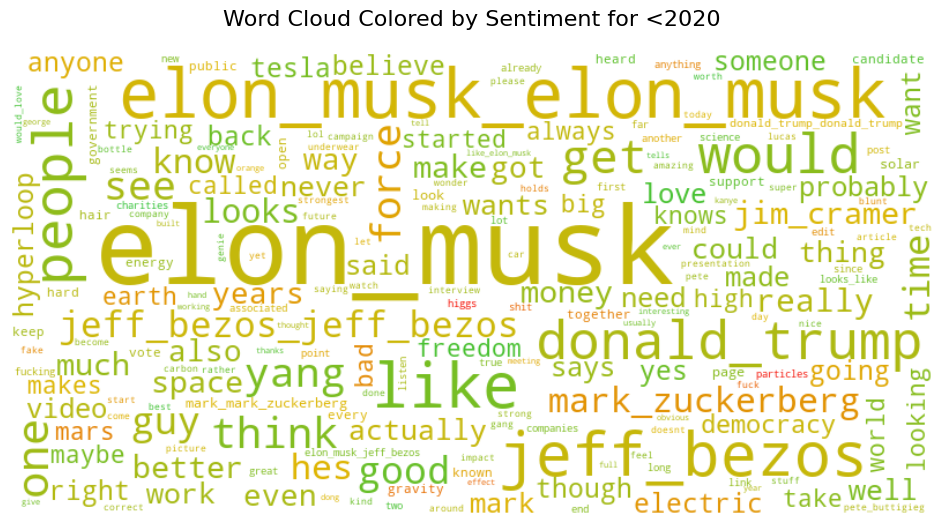


LSA Topics (num_topics=5):
Topic 0: 0.880*"elon_musk" + 0.248*"elon_musk_elon_musk" + 0.135*"jeff_bezos" + 0.122*"like" + 0.107*"donald_trump" + 0.088*"would" + 0.078*"think" + 0.076*"people"
Topic 1: -0.759*"force" + -0.238*"gravity" + -0.232*"together" + -0.232*"associated" + -0.186*"known" + -0.185*"holds" + -0.142*"called" + -0.140*"electric"
Topic 2: 0.455*"like" + 0.324*"would" + 0.250*"people" + -0.238*"elon_musk_elon_musk" + -0.204*"jeff_bezos" + -0.172*"elon_musk" + 0.162*"think" + 0.133*"charities"
Topic 3: -0.724*"jeff_bezos" + -0.305*"jeff_bezos_jeff_bezos" + -0.175*"like" + -0.167*"see" + 0.152*"elon_musk" + -0.133*"would" + -0.131*"high" + -0.120*"carbon"
Topic 4: 0.285*"jeff_bezos" + -0.272*"donald_trump" + 0.254*"people" + -0.213*"solar" + 0.175*"democracy" + -0.173*"carbon" + -0.173*"emissions" + 0.172*"think"


/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/url


Coherence Score: 0.3882


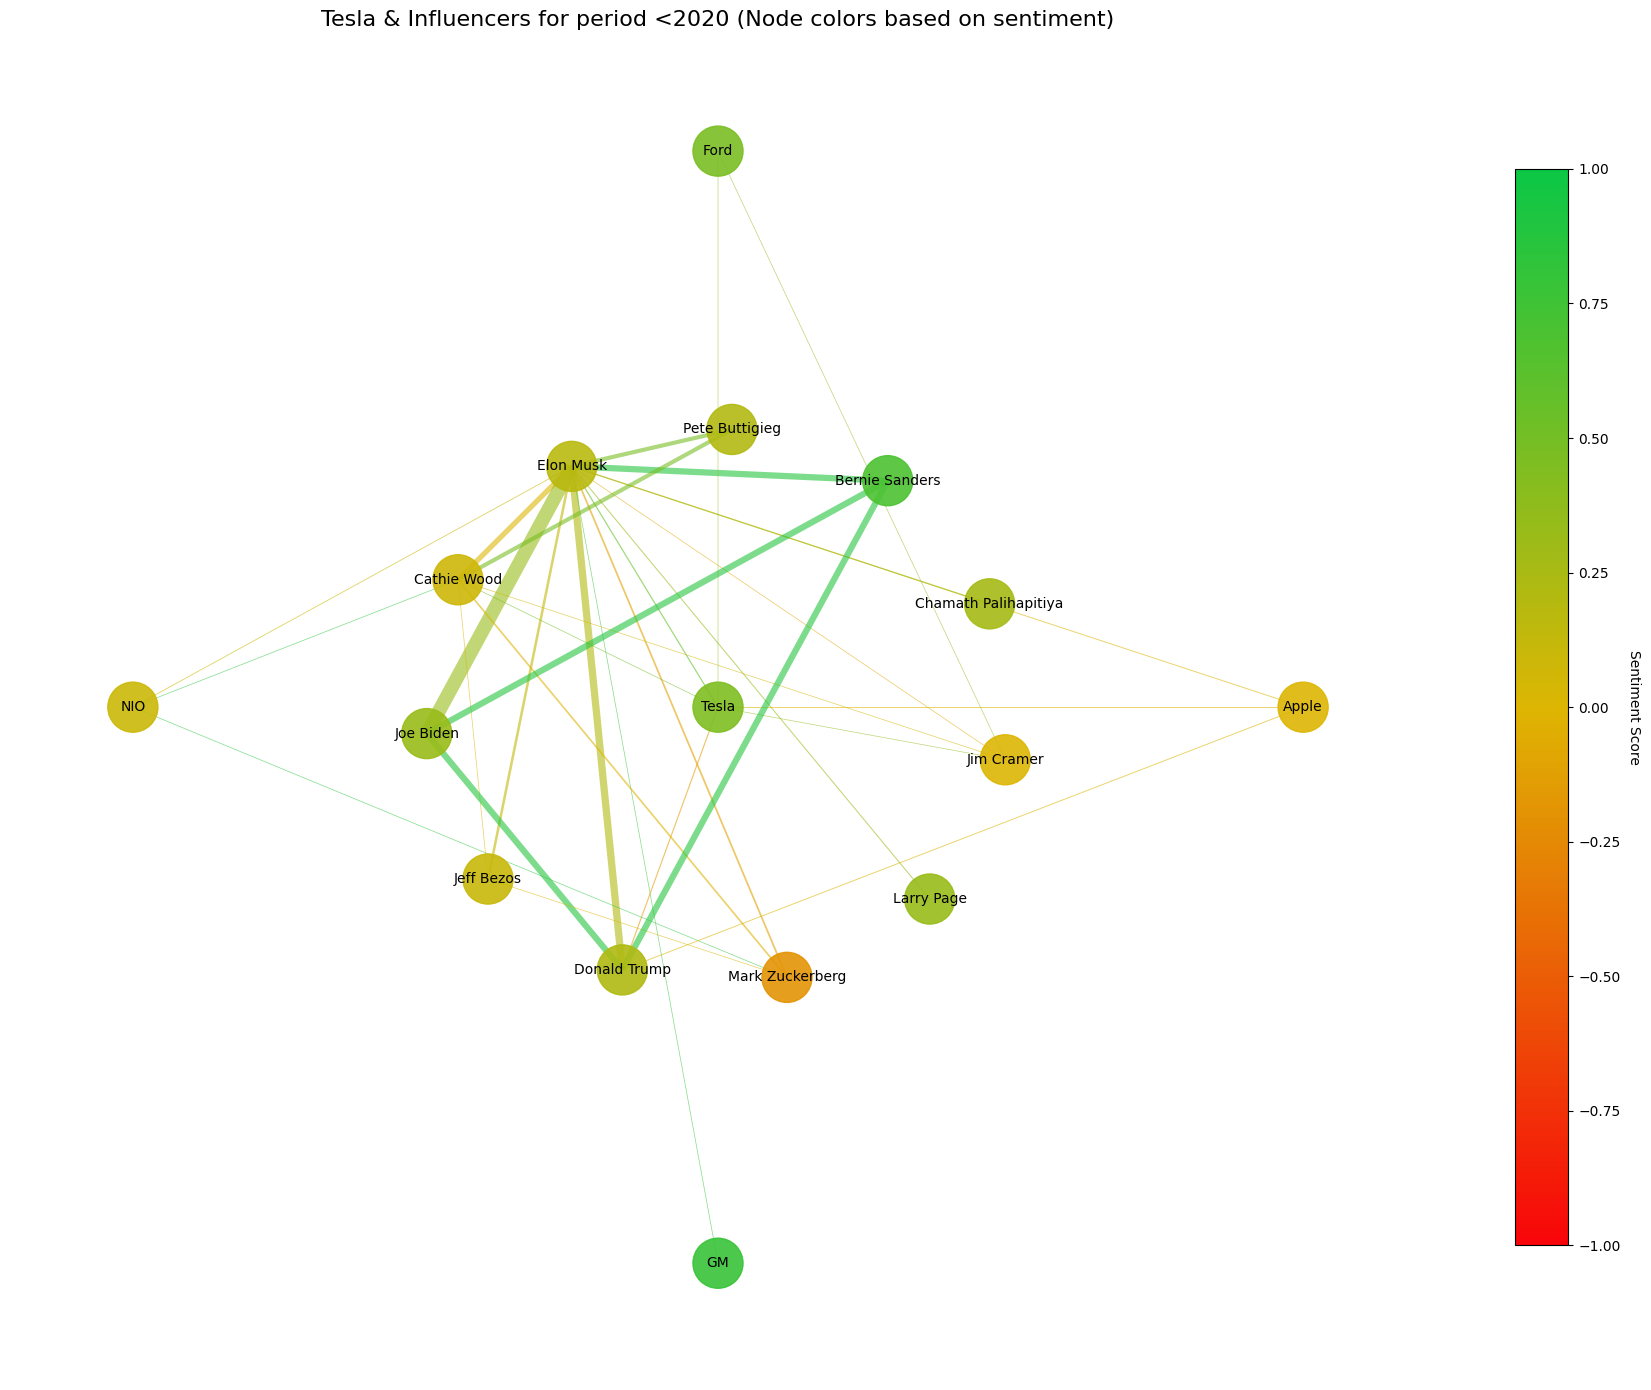


=== Processing period: 2022-2023 | Posts: 51 ===


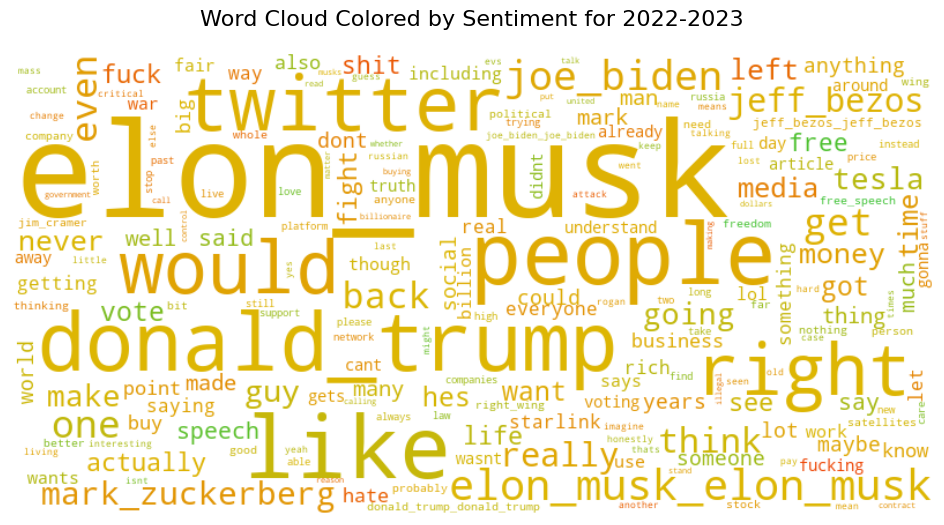


LSA Topics (num_topics=5):
Topic 0: 0.804*"elon_musk" + 0.200*"donald_trump" + 0.180*"elon_musk_elon_musk" + 0.150*"twitter" + 0.128*"like" + 0.117*"would" + 0.112*"people" + 0.110*"vote"
Topic 1: -0.286*"like" + 0.243*"elon_musk" + -0.210*"left" + -0.146*"years" + -0.142*"past" + -0.138*"constantly" + -0.123*"back" + -0.106*"made"
Topic 2: 0.306*"people" + 0.284*"right" + -0.216*"elon_musk" + 0.195*"stock" + 0.188*"like" + 0.155*"think" + 0.153*"buy" + 0.132*"say"
Topic 3: 0.361*"jeff_bezos" + -0.318*"donald_trump" + 0.218*"contract" + 0.213*"board" + 0.211*"lawsuit" + -0.177*"vote" + 0.173*"company" + 0.168*"stock"
Topic 4: 0.317*"right" + -0.283*"stock" + 0.215*"left" + -0.213*"buy" + -0.187*"back" + -0.161*"pressure" + -0.142*"vote" + 0.127*"people"


/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/url


Coherence Score: 0.3498


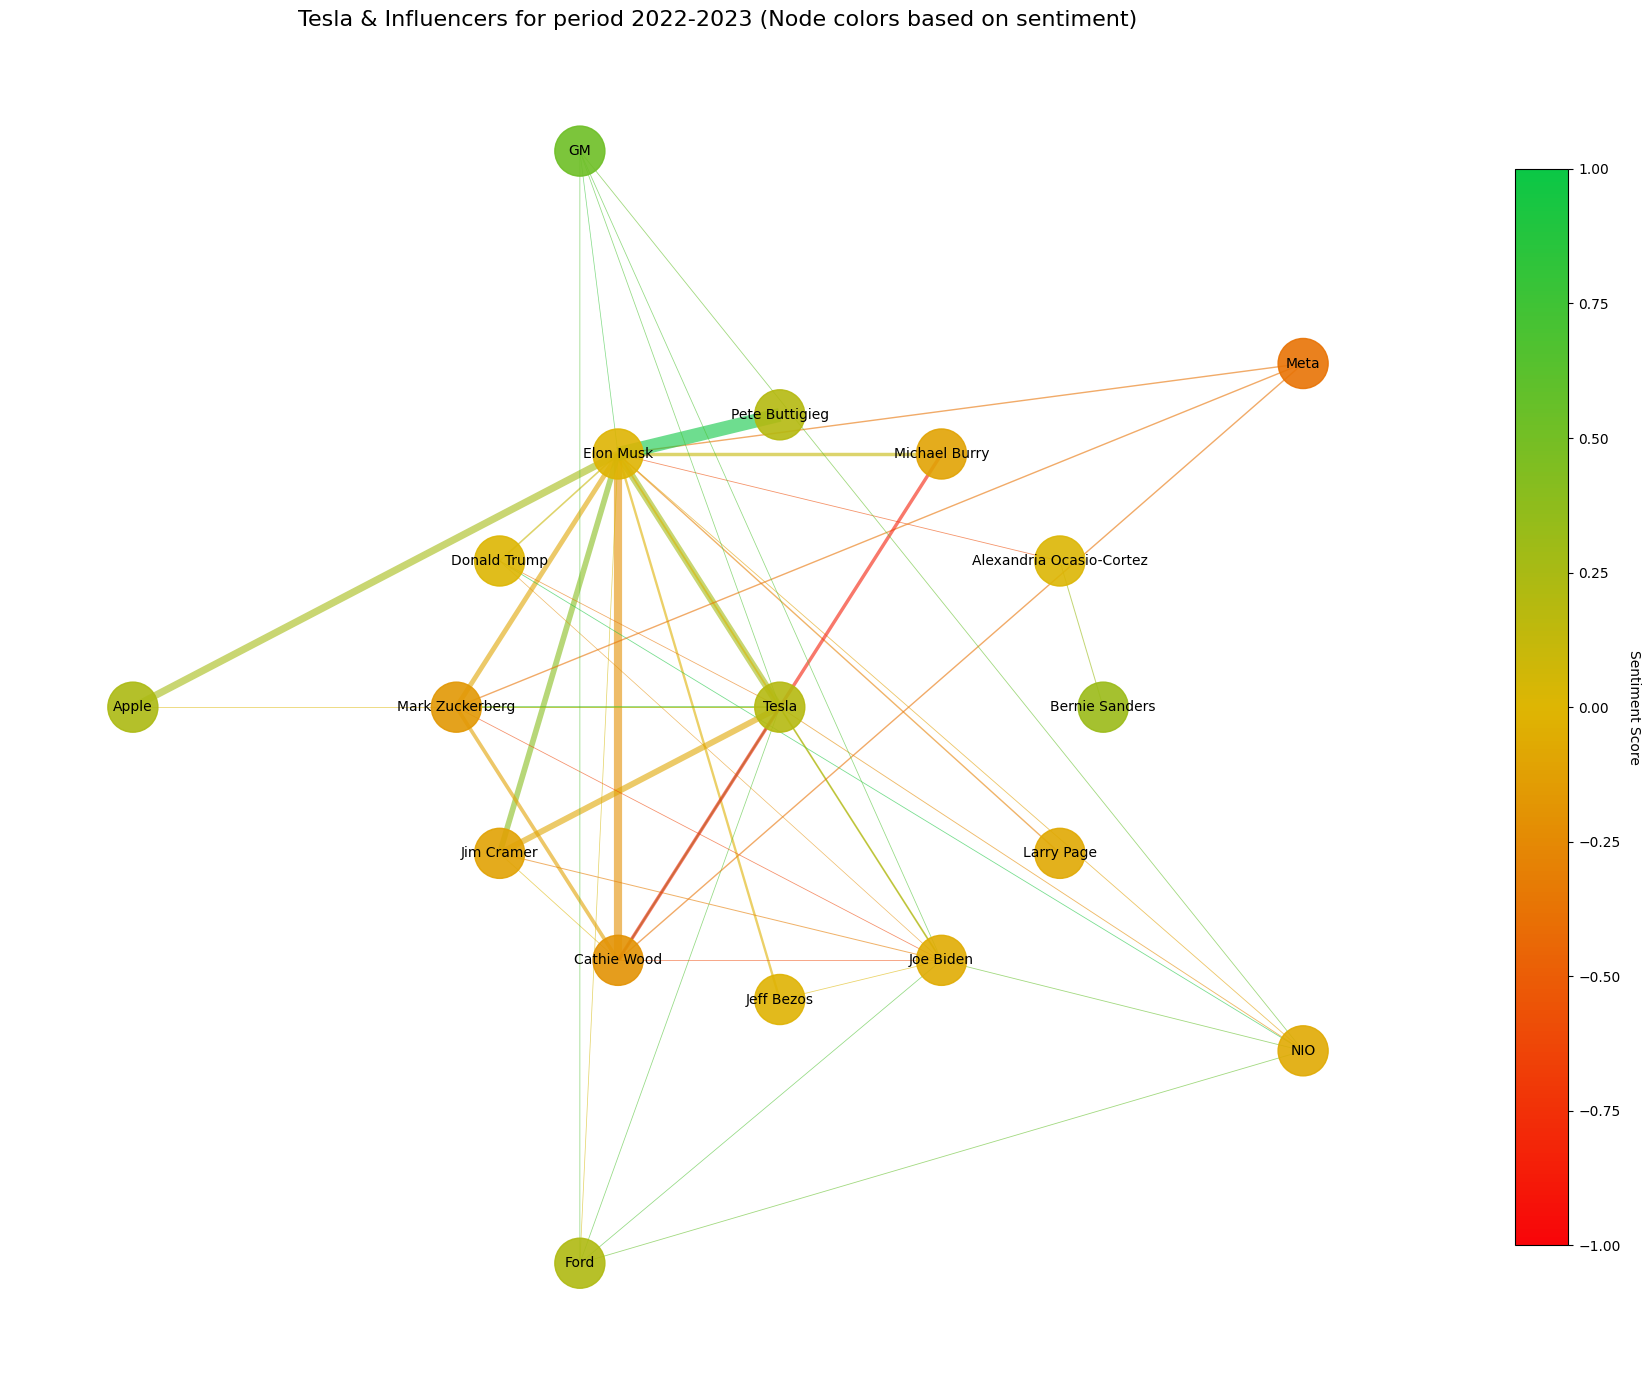


=== Processing period: 2020-2021 | Posts: 67 ===


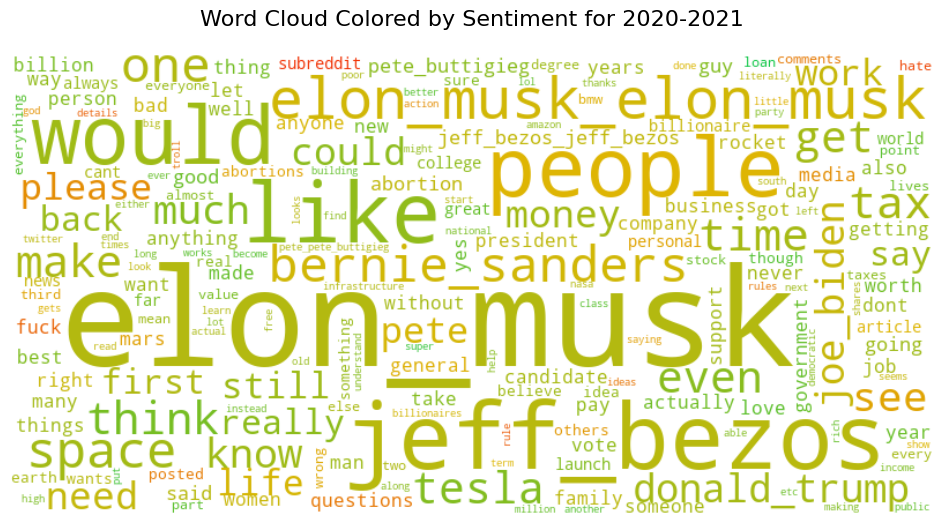


LSA Topics (num_topics=5):
Topic 0: 0.345*"abortion" + 0.232*"elon_musk" + 0.207*"lives" + 0.196*"life" + 0.164*"one" + 0.158*"donald_trump" + 0.157*"say" + 0.152*"joe_biden"
Topic 1: -0.371*"elon_musk" + -0.206*"tax" + -0.189*"pay" + -0.187*"money" + 0.170*"please" + -0.156*"billion" + -0.148*"year" + 0.146*"abortion"
Topic 2: -0.284*"elon_musk" + -0.202*"please" + 0.201*"abortion" + -0.153*"tax" + -0.137*"pay" + -0.134*"money" + -0.133*"subreddit" + -0.133*"questions"
Topic 3: -0.650*"elon_musk" + -0.223*"elon_musk_elon_musk" + -0.207*"jeff_bezos" + 0.204*"pay" + 0.191*"money" + 0.173*"tax" + 0.149*"year" + 0.137*"billion"
Topic 4: 0.269*"like" + -0.225*"elon_musk" + 0.201*"would" + 0.191*"tax" + 0.185*"people" + 0.182*"get" + 0.146*"good" + -0.127*"abortion"


/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/url


Coherence Score: 0.5465


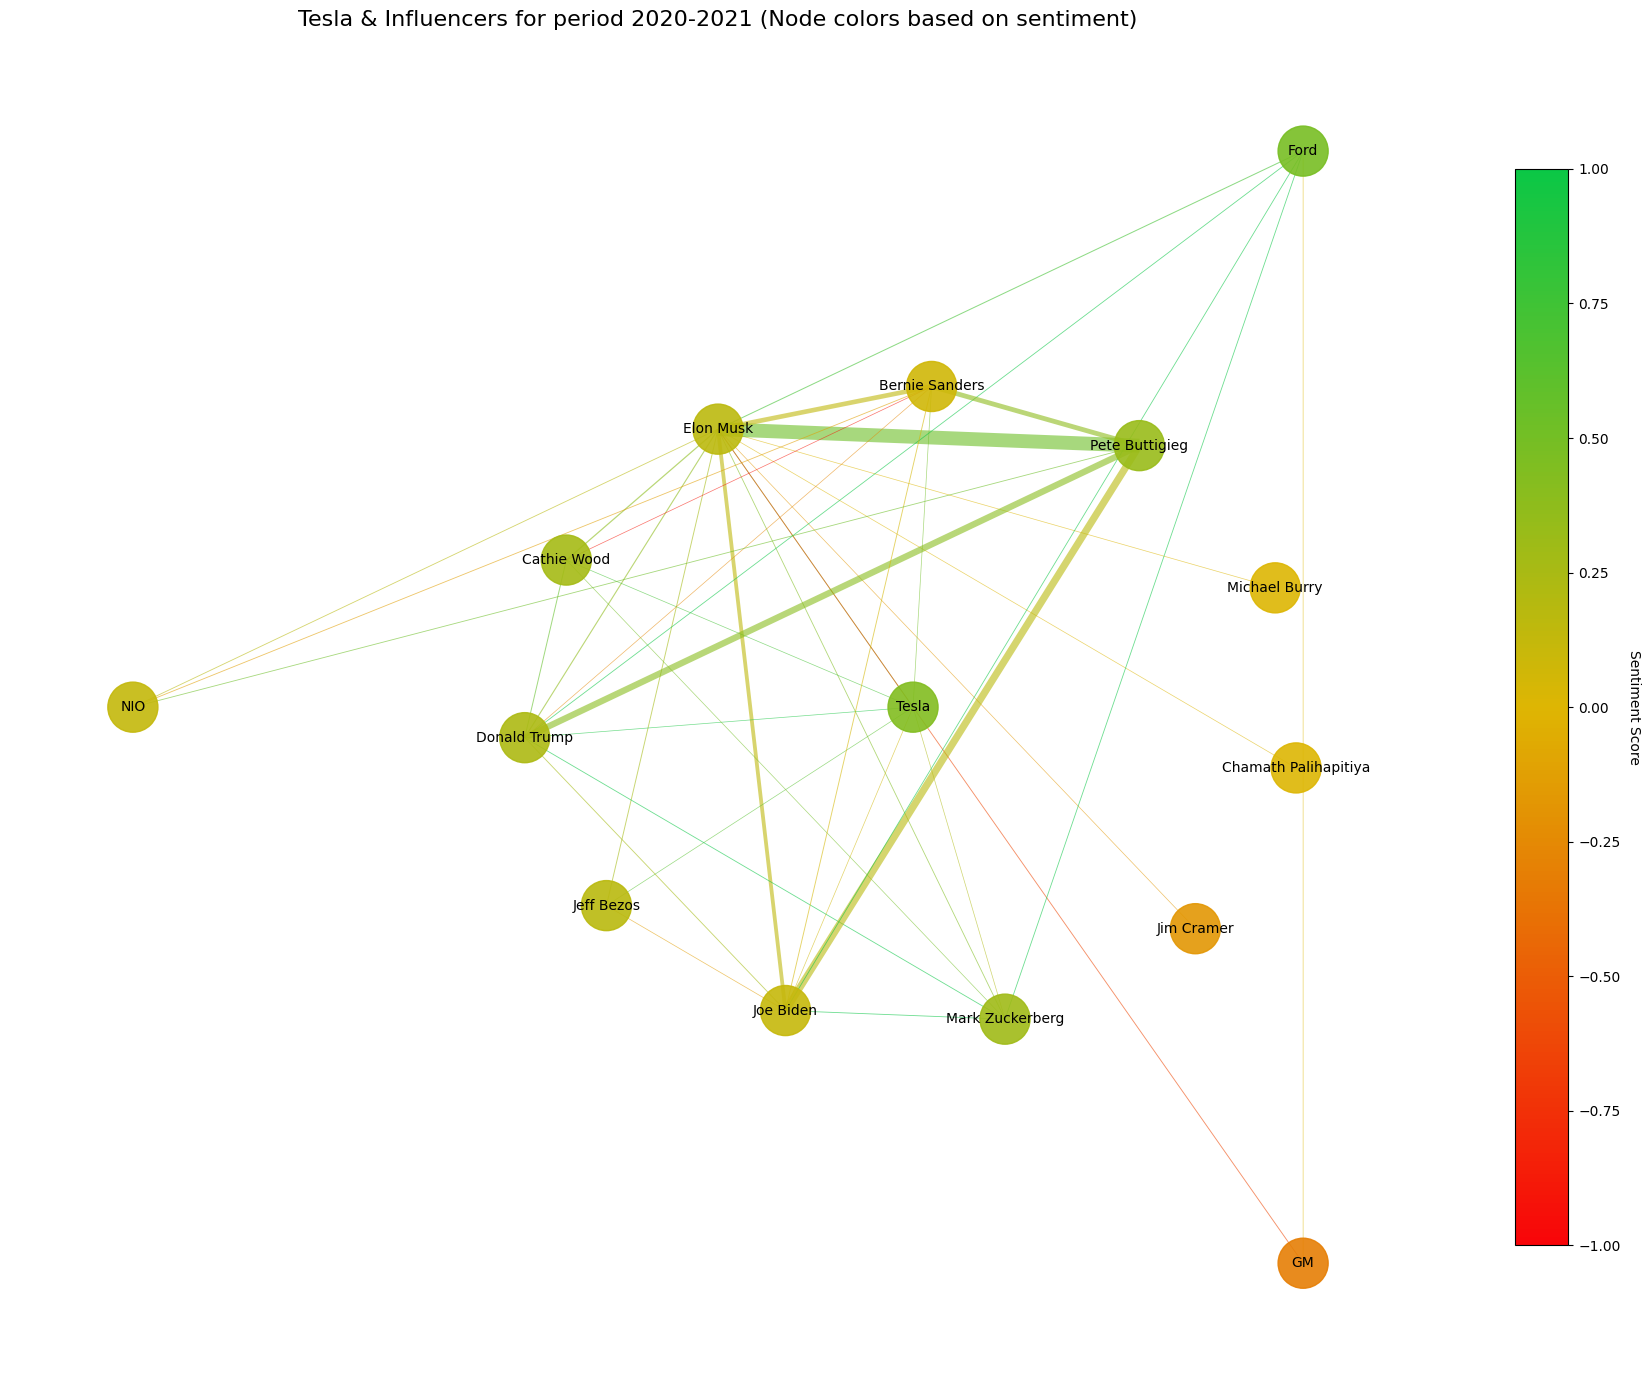


=== Processing period: 2024-2025 | Posts: 42 ===


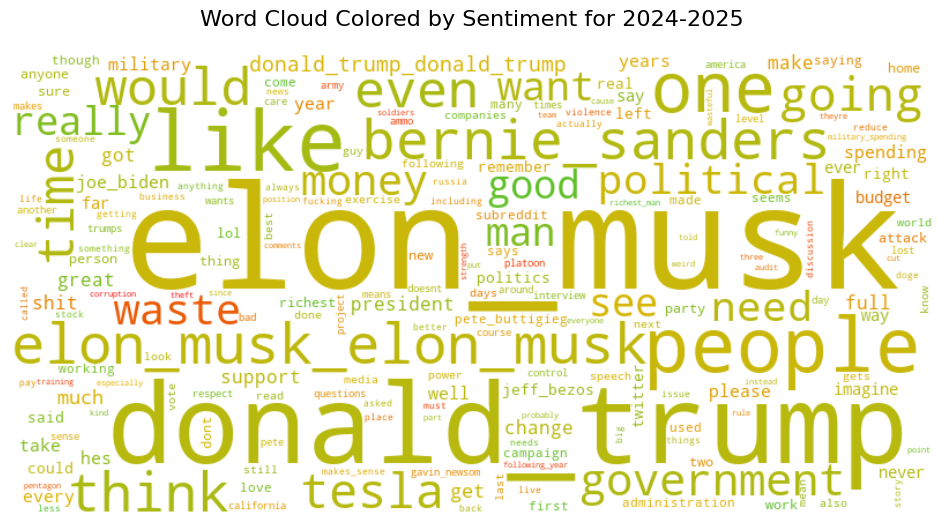


LSA Topics (num_topics=5):
Topic 0: 0.207*"every" + 0.166*"year" + 0.164*"days" + 0.164*"platoon" + 0.164*"ammo" + 0.132*"would" + 0.129*"want" + 0.124*"following"
Topic 1: 0.739*"elon_musk" + 0.352*"donald_trump" + 0.142*"elon_musk_elon_musk" + 0.120*"like" + 0.114*"people" + 0.099*"even" + 0.082*"one" + 0.075*"bernie_sanders"
Topic 2: 0.299*"please" + 0.224*"subreddit" + 0.150*"questions" + 0.149*"discussion" + 0.149*"moderators" + -0.125*"elon_musk" + 0.076*"rule" + 0.076*"attack"
Topic 3: 0.194*"corruption" + 0.194*"theft" + -0.172*"elon_musk" + 0.135*"far" + 0.133*"years" + 0.129*"operations" + 0.129*"laid" + 0.129*"veterans"
Topic 4: 0.519*"donald_trump" + -0.375*"elon_musk" + 0.265*"president" + 0.260*"hes" + 0.210*"pete_buttigieg" + 0.205*"even" + 0.194*"donald_trump_donald_trump" + 0.148*"aware"


/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yonatangolan/Desktop/github/University/NLP/.nlp_venv/lib/python3.9/site-packages/url


Coherence Score: 0.6680


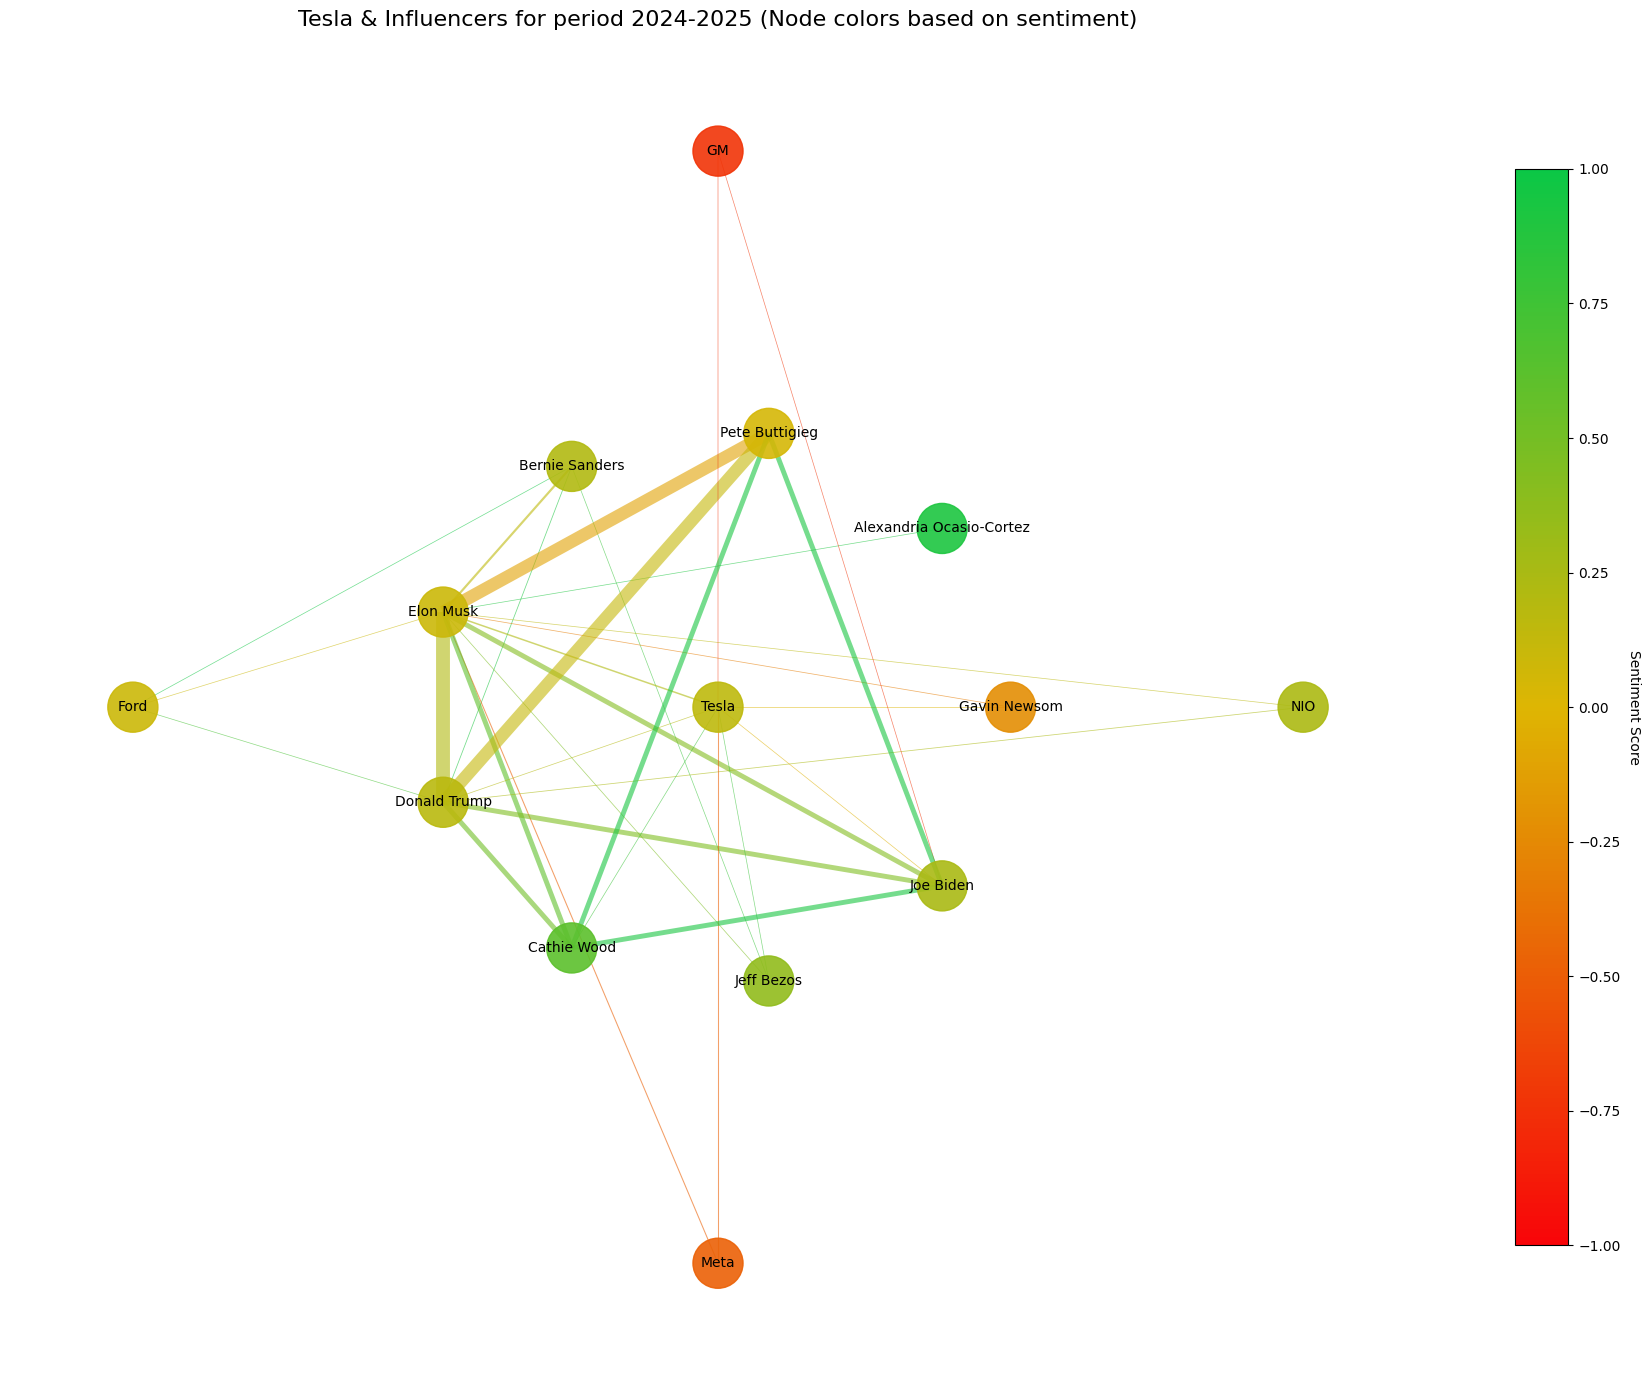

In [13]:
import os
import csv
from collections import defaultdict

# Ensure output directories exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("graphs_analysis", exist_ok=True)

client = RedditClient()
processor = Processor()
all_posts = []

# Uncomment to fetch new posts
# client.fetch_all_posts()
all_posts = client.get_all_posts()
processed_posts = processor.process_posts(all_posts)

posts_by_period = defaultdict(list)
for post in processed_posts:
    for period in post['periods']:
        posts_by_period[period].append(post)

period_graphs = {}
sentiment_over_time = defaultdict(dict)

for period, posts in posts_by_period.items():
    print(f"\n=== Processing period: {period} | Posts: {len(posts)} ===")

    # Build and analyze graph
    gm = GraphMaker(period)
    gm.build_graph(posts)
    gm.finalize_graph()
    period_graphs[period] = gm
    gm.save_graph_info()
    gm.export_edge_sentiment_analysis(f"graphs_analysis/sentiment_edges_{period}.csv")

    # Text analysis
    text_analysis = TextAnalysis(
        posts=posts,
        period=period,
        aliases=CONFIG.ALIASES,
        ngram_range=(1, 2)  # use unigrams and bigrams
    )

    text_analysis.process_all_text()
    individual_stats = text_analysis.get_individual_sentiments()
    text_analysis.generate_word_cloud()

    # Save summary stats
    summary = text_analysis.get_summary_stats()
    with open(f"outputs/summary_stats_{period}.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Value"])
        for key, value in summary.items():
            writer.writerow([key, value])

    # Save most common words
    common_words = text_analysis.get_most_common_words(n=50)
    with open(f"outputs/common_words_{period}.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Word", "Count", "Average Sentiment"])
        for word, count in common_words:
            sentiment = text_analysis.averaged_scores.get(word, 0)
            writer.writerow([word, count, round(sentiment, 4)])

    # Save sentiment extremes
    extremes = text_analysis.get_sentiment_extremes(n=10)
    for sentiment_type, word_list in extremes.items():
        with open(f"outputs/{sentiment_type}_{period}.csv", "w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Word", "Average Sentiment", "Count"])
            for word, sentiment in word_list:
                count = text_analysis.word_counts[word]
                writer.writerow([word, round(sentiment, 4), count])

    # Save top TF-IDF n-grams
    tfidf_words = text_analysis.get_top_tfidf_words(top_n=50)
    with open(f"outputs/tfidf_words_{period}.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Word", "TF-IDF Score"])
        writer.writerows([(word, round(score, 5)) for word, score in tfidf_words])

    # Save individual entity sentiment stats
    with open(f"outputs/entity_sentiments_{period}.csv", "w", newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            "name", "token", "mention_count", "average_sentiment", "sentiment_std_dev"
        ])
        writer.writeheader()
        for stat in individual_stats:
            writer.writerow(stat)

    # Store sentiment by entity over time
    for stat in individual_stats:
        sentiment_over_time[stat['name']][period] = stat['average_sentiment']

    # Topic modeling via LSA
    lsa_result = text_analysis.run_lsa()
    if lsa_result and lsa_result['topics']:
        with open(f"outputs/lsa_topics_{period}.csv", "w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Topic Index", "Terms"])
            for i, topic in enumerate(lsa_result['topics']):
                writer.writerow([i, topic[1]])

    # Visualize graph
    gm.visualize()

# Save overall sentiment evolution
with open("outputs/sentiment_over_time.csv", "w", newline='') as f:
    writer = csv.writer(f)
    all_periods = sorted(posts_by_period.keys())
    header = ["Entity"] + all_periods
    writer.writerow(header)
    for entity, sentiments in sentiment_over_time.items():
        row = [entity] + [round(sentiments.get(period, 0), 4) for period in all_periods]
        writer.writerow(row)